In [113]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import json
import os
from PIL import Image
from torchvision.transforms import transforms, InterpolationMode
from torchvision.transforms import functional as F
import numpy as np

In [114]:
class encoderBlocks(nn.Module):
    def __init__(self,levelwise_filter_config):
        super().__init__()
        self.network_block=nn.Sequential(
            nn.Conv2d(in_channels=levelwise_filter_config[0],out_channels=levelwise_filter_config[1],kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=levelwise_filter_config[1],out_channels=levelwise_filter_config[2],kernel_size=3,stride=1,padding=1),
            nn.ReLU()
        )
        self.pool=nn.MaxPool2d(kernel_size=2,stride=2)
    def forward(self,x):
        feature_maps=self.network_block(x)
        max_pooled_output=self.pool(feature_maps)
        return max_pooled_output,feature_maps

In [115]:
class encoder(nn.Module):
    def __init__(self,no_of_blocks,block_wise_filter_config):
        super().__init__()
        assert no_of_blocks==len(block_wise_filter_config)
        self.encoder=nn.ModuleList(
            [encoderBlocks(block_wise_filter_config[i]) for i in range(no_of_blocks)]
        )
    def forward(self,x):
        skip_inputs=[]
        for block in self.encoder:
            x,feature_maps=block(x)
            skip_inputs.append(feature_maps)
        return x,skip_inputs

In [116]:
class bottleNeckLayer(nn.Module):
    def __init__(self,bottleneck_filter_config):
        super().__init__()
        self.network=nn.Sequential(
            nn.Conv2d(in_channels=bottleneck_filter_config[0],out_channels=bottleneck_filter_config[1],kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=bottleneck_filter_config[1],out_channels=bottleneck_filter_config[2],kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=bottleneck_filter_config[2],out_channels=bottleneck_filter_config[2]//2,kernel_size=2,stride=2,padding=0)
        )
    def forward(self,x):
        bottleneck_output=self.network(x)
        return bottleneck_output

In [117]:
class decoderBlock(nn.Module):
    def __init__(self,levelwise_filter_config):
        super().__init__()
        self.network=nn.Sequential(
            nn.Conv2d(in_channels=levelwise_filter_config[0],out_channels=levelwise_filter_config[1],kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=levelwise_filter_config[1],out_channels=levelwise_filter_config[2],kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=levelwise_filter_config[2],out_channels=levelwise_filter_config[2]//2,kernel_size=2,stride=2,padding=0)
        )
    def forward(self,x,y):
        ### assiming x is networks output and y is skip connections input.
        #### batch_size,chanel,height,width
        # outputs_dim=x.shape[2]
        # all_side_cropping_pad=(y.shape[2]-outputs_dim)//2
        # y=y[:,:,all_side_cropping_pad:y.shape[2]-all_side_cropping_pad,all_side_cropping_pad:y.shape[3]-all_side_cropping_pad]
        assert x.shape==y.shape
        combined_input=torch.cat([x,y],dim=1)
        output=self.network(combined_input)
        return output


In [118]:
class decoder(nn.Module):
    ## will need 3 decoder block
    def __init__(self,no_of_blocks,block_wise_filter_config):
        super().__init__()
        self.decoder=nn.ModuleList(
            [decoderBlock(block_wise_filter_config[i]) for i in range(no_of_blocks)]
        )
        self.final_block=nn.Sequential(
            nn.Conv2d(in_channels=128,out_channels=64,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=64,out_channels=64,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=64,out_channels=2,kernel_size=1,stride=1,padding=0)
        )
    def forward(self,bottlenecks_output,skip_inputs):
        for i,block in enumerate(self.decoder):
            bottlenecks_output=block(bottlenecks_output,skip_inputs[-(i+1)])

        x=bottlenecks_output
        y=skip_inputs[0]
        # outputs_dim=x.shape[2]
        # all_side_cropping_pad=(y.shape[2]-outputs_dim)//2
        # y=y[:,:,all_side_cropping_pad:y.shape[2]-all_side_cropping_pad,all_side_cropping_pad:y.shape[3]-all_side_cropping_pad]
        assert x.shape==y.shape
        combined_input=torch.cat([x,y],dim=1)
        final_output=self.final_block(combined_input)
        return final_output


In [119]:
class Unet(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.encoder=encoder(config['encoder']['no_of_blocks'],config['encoder']['block_wise_filter_config'])
        self.bottle_neck=bottleNeckLayer(config['bottleneck_filter_config'])
        self.decoder=decoder(config['decoder']['no_of_blocks'],config['decoder']['block_wise_filter_config'])

    def forward(self,x):
        encoder_output,skip_inputs=self.encoder(x)
        bottleneck_output=self.bottle_neck(encoder_output)
        decoder_output=self.decoder(bottleneck_output,skip_inputs)
        return decoder_output

In [120]:
import json

# Open and load JSON file
with open("./config.json", "r") as f:
    data = json.load(f)

In [121]:
UNET=Unet(data)

In [122]:
input=torch.randint(0,255,(2,3,256,256),dtype=torch.float32)

In [123]:
input.shape

torch.Size([2, 3, 256, 256])

In [124]:
a=UNET(input)

In [125]:
a.shape

torch.Size([2, 2, 256, 256])

#### DATA PIPELINE

In [126]:
image_dir=r"E:\Unet-architechture-replication-from-orginal-paper\data\Kvasir-SEG\images"
mask_dir=r"E:\Unet-architechture-replication-from-orginal-paper\data\Kvasir-SEG\masks"

In [127]:
image_files=os.listdir(image_dir)
mask_files=os.listdir(mask_dir)

In [128]:
image_files

['cju0qkwl35piu0993l0dewei2.jpg',
 'cju0qoxqj9q6s0835b43399p4.jpg',
 'cju0qx73cjw570799j4n5cjze.jpg',
 'cju0roawvklrq0799vmjorwfv.jpg',
 'cju0rx1idathl0835detmsp84.jpg',
 'cju0s2a9ekvms080138tjjpxr.jpg',
 'cju0s690hkp960855tjuaqvv0.jpg',
 'cju0sr5ghl0nd08789uzf1raf.jpg',
 'cju0sxqiclckk08551ycbwhno.jpg',
 'cju0t4oil7vzk099370nun5h9.jpg',
 'cju0tl3uz8blh0993wxvn7ly3.jpg',
 'cju0u2g7pmnux0801vkk47ivj.jpg',
 'cju0u82z3cuma0835wlxrnrjv.jpg',
 'cju0ue769mxii08019zqgdbxn.jpg',
 'cju0vtox5ain6099360pu62rp.jpg',
 'cju13cgqmnhwn0988yrainhcp.jpg',
 'cju13fwthn9mq0835gacxgy01.jpg',
 'cju13hp5rnbjx0835bf0jowgx.jpg',
 'cju14g8o4xui30878gkgbrvqj.jpg',
 'cju14hjh2ob2o0835ouz3r5aa.jpg',
 'cju14pxbaoksp0835qzorx6g6.jpg',
 'cju15czxqp3lv0835jvhgzurz.jpg',
 'cju15jr8jz8sb0855ukmkswkz.jpg',
 'cju15l5ubz9yh0855b3ivdpse.jpg',
 'cju15mhjczc8z0801kit5c6di.jpg',
 'cju15ptjtppz40988odsm9azx.jpg',
 'cju15wdt3zla10801odjiw7sy.jpg',
 'cju160wshltz10993i1gmqxbe.jpg',
 'cju16ach3m1da0993r1dq3sn2.jpg',
 'cju16b6ynq8e

In [129]:
images_files_path=[]
mask_files_path=[]

for i in range(len(image_files)):
    images_files_path.append(os.path.join(image_dir,image_files[i]))

for i in range(len(mask_files)):
    mask_files_path.append(os.path.join(mask_dir,mask_files[i]))

In [130]:
len(images_files_path)

1000

In [131]:
len(mask_files_path)

1000

In [132]:
images_files_path.sort()
mask_files_path.sort()

In [133]:
images_files_path

['E:\\Unet-architechture-replication-from-orginal-paper\\data\\Kvasir-SEG\\images\\cju0qkwl35piu0993l0dewei2.jpg',
 'E:\\Unet-architechture-replication-from-orginal-paper\\data\\Kvasir-SEG\\images\\cju0qoxqj9q6s0835b43399p4.jpg',
 'E:\\Unet-architechture-replication-from-orginal-paper\\data\\Kvasir-SEG\\images\\cju0qx73cjw570799j4n5cjze.jpg',
 'E:\\Unet-architechture-replication-from-orginal-paper\\data\\Kvasir-SEG\\images\\cju0roawvklrq0799vmjorwfv.jpg',
 'E:\\Unet-architechture-replication-from-orginal-paper\\data\\Kvasir-SEG\\images\\cju0rx1idathl0835detmsp84.jpg',
 'E:\\Unet-architechture-replication-from-orginal-paper\\data\\Kvasir-SEG\\images\\cju0s2a9ekvms080138tjjpxr.jpg',
 'E:\\Unet-architechture-replication-from-orginal-paper\\data\\Kvasir-SEG\\images\\cju0s690hkp960855tjuaqvv0.jpg',
 'E:\\Unet-architechture-replication-from-orginal-paper\\data\\Kvasir-SEG\\images\\cju0sr5ghl0nd08789uzf1raf.jpg',
 'E:\\Unet-architechture-replication-from-orginal-paper\\data\\Kvasir-SEG\\image

In [134]:
mask_files_path

['E:\\Unet-architechture-replication-from-orginal-paper\\data\\Kvasir-SEG\\masks\\cju0qkwl35piu0993l0dewei2.jpg',
 'E:\\Unet-architechture-replication-from-orginal-paper\\data\\Kvasir-SEG\\masks\\cju0qoxqj9q6s0835b43399p4.jpg',
 'E:\\Unet-architechture-replication-from-orginal-paper\\data\\Kvasir-SEG\\masks\\cju0qx73cjw570799j4n5cjze.jpg',
 'E:\\Unet-architechture-replication-from-orginal-paper\\data\\Kvasir-SEG\\masks\\cju0roawvklrq0799vmjorwfv.jpg',
 'E:\\Unet-architechture-replication-from-orginal-paper\\data\\Kvasir-SEG\\masks\\cju0rx1idathl0835detmsp84.jpg',
 'E:\\Unet-architechture-replication-from-orginal-paper\\data\\Kvasir-SEG\\masks\\cju0s2a9ekvms080138tjjpxr.jpg',
 'E:\\Unet-architechture-replication-from-orginal-paper\\data\\Kvasir-SEG\\masks\\cju0s690hkp960855tjuaqvv0.jpg',
 'E:\\Unet-architechture-replication-from-orginal-paper\\data\\Kvasir-SEG\\masks\\cju0sr5ghl0nd08789uzf1raf.jpg',
 'E:\\Unet-architechture-replication-from-orginal-paper\\data\\Kvasir-SEG\\masks\\cju0sx

In [135]:
for i in range(1000):
    assert (images_files_path[i].split('\\')[-1]==mask_files_path[i].split('\\')[-1])

In [136]:
img_size = 256

img_size = 256

In [137]:
image_transform=transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5],std=[0.5,0.5,0.5])
]
)

In [138]:
mask_transform = transforms.Compose([
    transforms.Resize((img_size, img_size), interpolation=InterpolationMode.NEAREST),
    transforms.Lambda(lambda mask: torch.from_numpy(np.array(mask) > 127).long())  # convert to 0/1 tensor
])

In [139]:
class segmentationDataset(Dataset):
    def __init__(self,images_files_path,mask_files_path):
        super().__init__()
        self.image_files_path=images_files_path
        self.mask_files_path=mask_files_path
        assert len(self.image_files_path)==len(self.mask_files_path), "Number of images and mask should match."
        self.image_transforms=image_transform
        self.mask_transforms=mask_transform

    def load_image_and_mask(self,index):
        image_path=self.image_files_path[index]
        mask_path=self.mask_files_path[index]
        image=Image.open(image_path).convert('RGB')
        mask=Image.open(mask_path).convert('L')
        return image,mask
    def __len__(self):
        return len(self.image_files_path)
    def __getitem__(self, index):
        image,mask=self.load_image_and_mask(index)
        transformed_image=self.image_transforms(image)
        transformed_mask=self.mask_transforms(mask)
        return transformed_image,transformed_mask
        

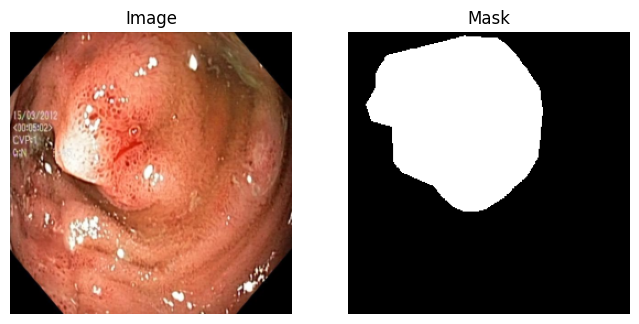

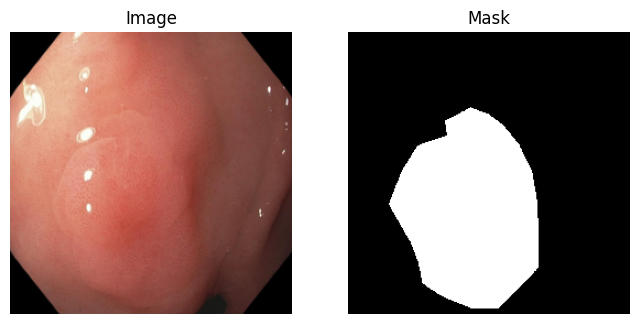

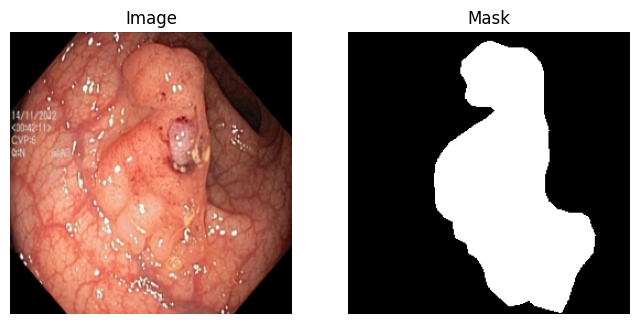

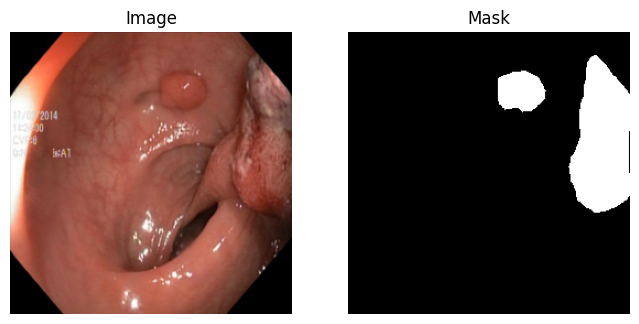

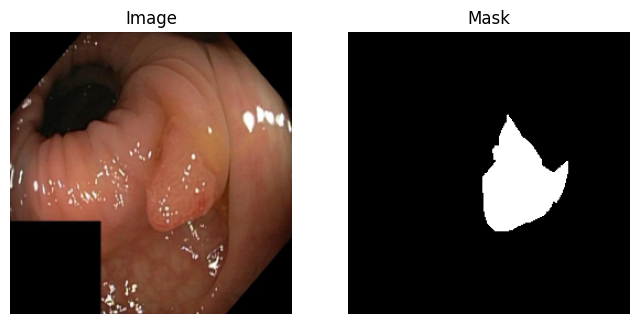

In [140]:
import matplotlib.pyplot as plt
import torch

# Assume dataset is your SegmentationDataset instance
dataset = segmentationDataset(images_files_path, mask_files_path)

def denormalize_image(img_tensor):
    """Convert normalized image tensor back to [0,1] for visualization"""
    mean = torch.tensor([0.5,0.5,0.5]).view(3,1,1)
    std  = torch.tensor([0.5,0.5,0.5]).view(3,1,1)
    img = img_tensor * std + mean
    img = torch.clamp(img, 0, 1)
    return img

# Visualize first 5 images
for i in range(5):
    img, mask = dataset[i]  # img: [3,H,W], mask: [H,W]
    
    img = denormalize_image(img).permute(1,2,0).numpy()  # [H,W,C] for matplotlib
    mask = mask.numpy()  # [H,W]
    
    fig, axes = plt.subplots(1,2, figsize=(8,4))
    axes[0].imshow(img)
    axes[0].set_title("Image")
    axes[0].axis('off')
    
    axes[1].imshow(mask, cmap='gray')
    axes[1].set_title("Mask")
    axes[1].axis('off')
    
    plt.show()


In [141]:
from torch.utils.data import random_split

In [142]:
len(dataset)

1000

In [143]:
train_size=int((len(dataset)*0.8))
test_size=int(len(dataset)-train_size)

In [144]:
print(train_size,test_size)

800 200


In [145]:
train_split,test_split=random_split(dataset,[train_size,test_size])

In [146]:
len(train_split)

800

In [147]:
len(test_split)

200

In [148]:
train_loader = DataLoader(train_split, batch_size=8, shuffle=True)
test_loader  = DataLoader(test_split, batch_size=8, shuffle=False)

In [149]:
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(UNET.parameters(),lr=1e-4)

In [150]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [151]:
from tqdm.notebook import tqdm
import time
import sys

In [152]:
epoch=10

In [ ]:
pbar=tqdm(range(epoch),desc="Epoch is running",leave=True,position=0)
for i in pbar:
    time.sleep(2)
    pbar.set_postfix({"Epoch": i})
    # pbar.write(str(i))
    running_loss=0.0
    running_acc=0.0

    UNET.train()
    train_progress_bar=tqdm(train_loader,desc="Iterating for batch",leave=False,position=1)
    for j,batch in enumerate(train_progress_bar):

        images,masks=batch
        images=images.to(device)
        masks=masks.to(device)

        optimizer.zero_grad()

        model_output=UNET(images)

        loss=criterion(model_output,masks)

        loss.backward()
        optimizer.step()

        running_loss+=loss.item()


        preds=torch.argmax(model_output,dim=1)
        acc=(preds==masks).float().mean()
        running_acc+=acc
        
        train_progress_bar.set_postfix({f"{j}th batch train loss:  ":loss.item(),f"{j}th train acc:  ":acc.item()})
        # train_progress_bar.write(str(j))
    train_progress_bar.close()
    train_loss=running_loss/len(train_loader)

    model.eval()
    val_loss=0.0
    val_acc=0.0

    with torch.no_grad():
        val_bar=tqdm(test_loader,desc="Validation",leave=False,position=1)

        for j,batch in val_bar:
            images,masks=batch
            images=images.to(device)
            masks=masks.to(device)
            outputs=UNET(images)
            loss=criterion(outputs,masks)
            val_loss+=loss.item()

            preds=torch.argmax(outputs,dim=1)
            acc=(preds==masks).float().mean()
            val_acc+=acc
            val_bar.set_postfix({f"{j}th batch test loss:  ":loss.item(),f"{j}th test acc:  ":acc.item()})

    val_loss/=len(test_loader)

    train_progress_bar.write(f"epoch {i} | train loss: {train_loss} | val loss: {val_loss} | train acc: {running_acc} | val acc: {val_acc}")

Epoch is running:   0%|          | 0/10 [00:00<?, ?it/s]

Iterating for batch:   0%|          | 0/100 [00:00<?, ?it/s]